# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.025503904
Average power, source: 0.0008100149


Average magnitude, target: 0.09133169
Average power, target: 0.009958185


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 2017.1973, train_label_loss: 4.0491, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3967.4354, train_label_loss: 3.3454, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4049.5151, train_label_loss: 3.0592, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4051.7618, train_label_loss: 2.7170, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4029.6420, train_label_loss: 2.6419, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3982.0358, train_label_loss: 2.1762, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4013.7841, train_label_loss: 1.9977, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4054.0133, train_label_loss: 1.6807, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4085.2321, train_label_loss: 1.5304, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4141.8444, train_label_loss: 1.5386, 


epoch: 1, source_val_acc_label: 0.8064, target_val_acc_label: 0.7712, source_val_label_loss: 1.4327, target_val_label_loss: 1.5851, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 510.3768, train_label_loss: 1.3059, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4046.4123, train_label_loss: 0.9835, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4135.2118, train_label_loss: 0.9964, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4124.0767, train_label_loss: 0.8653, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4146.3451, train_label_loss: 0.7519, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4064.3014, train_label_loss: 0.8220, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4140.6523, train_label_loss: 0.6984, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4148.7618, train_label_loss: 0.6332, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4170.0204, train_label_loss: 0.8482, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4219.7377, train_label_loss: 0.7827, 


epoch: 2, source_val_acc_label: 0.8551, target_val_acc_label: 0.8094, source_val_label_loss: 0.8068, target_val_label_loss: 1.0435, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 498.2417, train_label_loss: 0.8003, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4029.8236, train_label_loss: 0.6832, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4131.1937, train_label_loss: 0.7206, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4125.3535, train_label_loss: 0.7856, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4124.2068, train_label_loss: 0.7685, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4055.3599, train_label_loss: 0.7867, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4124.7683, train_label_loss: 0.4635, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4132.7640, train_label_loss: 0.5986, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4162.0081, train_label_loss: 0.4781, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4222.0150, train_label_loss: 0.5457, 


epoch: 3, source_val_acc_label: 0.8891, target_val_acc_label: 0.8280, source_val_label_loss: 0.6513, target_val_label_loss: 0.9493, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 499.6797, train_label_loss: 0.7970, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4034.7901, train_label_loss: 0.5784, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4134.8967, train_label_loss: 0.5696, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4129.7128, train_label_loss: 0.8533, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4143.6920, train_label_loss: 0.6353, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4057.4095, train_label_loss: 0.4607, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4132.3270, train_label_loss: 0.5934, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4127.7051, train_label_loss: 0.5435, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4173.0446, train_label_loss: 0.5162, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4226.0399, train_label_loss: 0.5792, 


epoch: 4, source_val_acc_label: 0.9109, target_val_acc_label: 0.8368, source_val_label_loss: 0.5521, target_val_label_loss: 0.8962, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 500.2435, train_label_loss: 0.4470, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4024.3480, train_label_loss: 0.3227, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4134.9892, train_label_loss: 0.4835, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4127.3108, train_label_loss: 0.4320, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4127.8472, train_label_loss: 0.5141, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4045.2496, train_label_loss: 0.3998, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4123.9557, train_label_loss: 0.4181, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4128.1848, train_label_loss: 0.4021, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4162.3144, train_label_loss: 0.3977, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4225.3031, train_label_loss: 0.5097, 


epoch: 5, source_val_acc_label: 0.9218, target_val_acc_label: 0.8506, source_val_label_loss: 0.4773, target_val_label_loss: 0.8398, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 497.5336, train_label_loss: 0.2757, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4037.4536, train_label_loss: 0.3302, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4135.6305, train_label_loss: 0.3180, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4131.3736, train_label_loss: 0.3559, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4127.5473, train_label_loss: 0.5336, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4064.1729, train_label_loss: 0.3163, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4136.8385, train_label_loss: 0.3381, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4121.4572, train_label_loss: 0.4326, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4159.3158, train_label_loss: 0.3704, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4228.8882, train_label_loss: 0.3701, 


epoch: 6, source_val_acc_label: 0.9314, target_val_acc_label: 0.8534, source_val_label_loss: 0.4442, target_val_label_loss: 0.8109, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 497.8278, train_label_loss: 0.6072, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4037.9694, train_label_loss: 0.3441, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4143.8447, train_label_loss: 0.3596, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4142.6458, train_label_loss: 0.3004, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4129.1523, train_label_loss: 0.4166, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4062.2351, train_label_loss: 0.3035, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4138.2734, train_label_loss: 0.2098, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4133.5613, train_label_loss: 0.3347, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4173.9173, train_label_loss: 0.3392, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4228.1553, train_label_loss: 0.3322, 


epoch: 7, source_val_acc_label: 0.9410, target_val_acc_label: 0.8526, source_val_label_loss: 0.3936, target_val_label_loss: 0.7983, 


epoch: 8, [batch: 1 / 45], examples_per_second: 516.4109, train_label_loss: 0.3189, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4041.8711, train_label_loss: 0.2383, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4132.7624, train_label_loss: 0.1654, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4127.5557, train_label_loss: 0.3163, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4130.9918, train_label_loss: 0.1557, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4053.5136, train_label_loss: 0.2709, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4133.0506, train_label_loss: 0.2862, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4119.1968, train_label_loss: 0.2992, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4169.0447, train_label_loss: 0.4615, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4225.8925, train_label_loss: 0.2016, 


epoch: 8, source_val_acc_label: 0.9436, target_val_acc_label: 0.8603, source_val_label_loss: 0.3746, target_val_label_loss: 0.7228, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 500.0198, train_label_loss: 0.2145, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4040.2762, train_label_loss: 0.2743, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4147.7014, train_label_loss: 0.1320, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4143.3170, train_label_loss: 0.1603, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4138.9723, train_label_loss: 0.1839, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4059.0381, train_label_loss: 0.1855, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4131.4425, train_label_loss: 0.4279, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4131.5536, train_label_loss: 0.2870, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4174.2803, train_label_loss: 0.2215, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4223.1301, train_label_loss: 0.1876, 


epoch: 9, source_val_acc_label: 0.9526, target_val_acc_label: 0.8641, source_val_label_loss: 0.3473, target_val_label_loss: 0.7382, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 497.4882, train_label_loss: 0.3158, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4029.2057, train_label_loss: 0.2578, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4127.7363, train_label_loss: 0.2926, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4125.3722, train_label_loss: 0.2151, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4126.9584, train_label_loss: 0.2501, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4045.8439, train_label_loss: 0.3929, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4122.8908, train_label_loss: 0.3129, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4133.1148, train_label_loss: 0.3091, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4160.2425, train_label_loss: 0.2375, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4227.8209, train_label_loss: 0.3551, 


epoch: 10, source_val_acc_label: 0.9519, target_val_acc_label: 0.8716, source_val_label_loss: 0.3383, target_val_label_loss: 0.6857, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 503.0381, train_label_loss: 0.2672, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4035.2126, train_label_loss: 0.1181, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4140.3583, train_label_loss: 0.3145, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4135.2727, train_label_loss: 0.2960, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4134.2571, train_label_loss: 0.5067, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4055.6579, train_label_loss: 0.1474, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4131.2735, train_label_loss: 0.2520, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4137.4695, train_label_loss: 0.2118, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4174.2215, train_label_loss: 0.1498, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4225.3735, train_label_loss: 0.4057, 


epoch: 11, source_val_acc_label: 0.9558, target_val_acc_label: 0.8735, source_val_label_loss: 0.3246, target_val_label_loss: 0.7037, 


New best


epoch: 12, [batch: 1 / 45], examples_per_second: 495.9939, train_label_loss: 0.2530, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4039.8587, train_label_loss: 0.1607, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4129.7637, train_label_loss: 0.3716, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4131.5414, train_label_loss: 0.3545, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4125.7952, train_label_loss: 0.2509, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4058.2430, train_label_loss: 0.4626, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4126.0309, train_label_loss: 0.2893, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4132.8517, train_label_loss: 0.1569, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4171.3985, train_label_loss: 0.4062, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4230.1267, train_label_loss: 0.2517, 


epoch: 12, source_val_acc_label: 0.9596, target_val_acc_label: 0.8774, source_val_label_loss: 0.3013, target_val_label_loss: 0.6582, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 501.7135, train_label_loss: 0.1173, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4041.5310, train_label_loss: 0.1577, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4139.9418, train_label_loss: 0.2586, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4140.8677, train_label_loss: 0.3022, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4122.6601, train_label_loss: 0.2116, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4067.9594, train_label_loss: 0.1765, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4128.9757, train_label_loss: 0.4255, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4139.4986, train_label_loss: 0.1249, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4169.1799, train_label_loss: 0.1303, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4225.5094, train_label_loss: 0.3989, 


epoch: 13, source_val_acc_label: 0.9609, target_val_acc_label: 0.8844, source_val_label_loss: 0.3008, target_val_label_loss: 0.6575, 


New best


epoch: 14, [batch: 1 / 45], examples_per_second: 502.6899, train_label_loss: 0.1668, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4029.2057, train_label_loss: 0.1431, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4114.5622, train_label_loss: 0.1932, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4129.7253, train_label_loss: 0.1624, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4120.8514, train_label_loss: 0.2394, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4057.7730, train_label_loss: 0.2488, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4128.8709, train_label_loss: 0.2882, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4136.6392, train_label_loss: 0.3528, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4171.7751, train_label_loss: 0.1238, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4223.0745, train_label_loss: 0.3069, 


epoch: 14, source_val_acc_label: 0.9532, target_val_acc_label: 0.8838, source_val_label_loss: 0.3296, target_val_label_loss: 0.6409, 


epoch: 15, [batch: 1 / 45], examples_per_second: 515.7523, train_label_loss: 0.3410, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4028.4690, train_label_loss: 0.2122, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4129.2993, train_label_loss: 0.1917, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4122.9229, train_label_loss: 0.3011, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4129.6464, train_label_loss: 0.1655, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4046.5069, train_label_loss: 0.1700, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4124.8791, train_label_loss: 0.1188, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4134.9374, train_label_loss: 0.2589, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4173.5033, train_label_loss: 0.3371, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4226.9065, train_label_loss: 0.1845, 


epoch: 15, source_val_acc_label: 0.9609, target_val_acc_label: 0.8902, source_val_label_loss: 0.2946, target_val_label_loss: 0.6404, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 499.5792, train_label_loss: 0.3371, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3996.6101, train_label_loss: 0.2648, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4127.8816, train_label_loss: 0.2485, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4132.8279, train_label_loss: 0.2406, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4131.5145, train_label_loss: 0.1846, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4053.2943, train_label_loss: 0.1707, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4136.4463, train_label_loss: 0.3025, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4133.4250, train_label_loss: 0.1713, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4172.2821, train_label_loss: 0.1516, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4206.3049, train_label_loss: 0.1019, 


epoch: 16, source_val_acc_label: 0.9596, target_val_acc_label: 0.8893, source_val_label_loss: 0.3099, target_val_label_loss: 0.6449, 


epoch: 17, [batch: 1 / 45], examples_per_second: 512.1853, train_label_loss: 0.3064, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4030.0619, train_label_loss: 0.1912, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4126.4493, train_label_loss: 0.2412, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4134.3571, train_label_loss: 0.1850, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4125.4159, train_label_loss: 0.1939, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4050.6108, train_label_loss: 0.2519, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4124.0321, train_label_loss: 0.1574, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4123.8621, train_label_loss: 0.1272, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4167.2158, train_label_loss: 0.1952, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4220.7143, train_label_loss: 0.2491, 


epoch: 17, source_val_acc_label: 0.9635, target_val_acc_label: 0.8889, source_val_label_loss: 0.2860, target_val_label_loss: 0.6225, 


epoch: 18, [batch: 1 / 45], examples_per_second: 517.3048, train_label_loss: 0.2176, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4041.6898, train_label_loss: 0.3205, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4137.3879, train_label_loss: 0.1699, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4134.9666, train_label_loss: 0.1789, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4137.2435, train_label_loss: 0.2050, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4057.7296, train_label_loss: 0.2659, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4131.4159, train_label_loss: 0.1595, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4126.5539, train_label_loss: 0.2944, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4172.1710, train_label_loss: 0.2167, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4223.0500, train_label_loss: 0.0808, 


epoch: 18, source_val_acc_label: 0.9577, target_val_acc_label: 0.8895, source_val_label_loss: 0.2959, target_val_label_loss: 0.6400, 


epoch: 19, [batch: 1 / 45], examples_per_second: 509.0907, train_label_loss: 0.2834, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4025.9585, train_label_loss: 0.1754, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4106.9059, train_label_loss: 0.0734, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4127.9919, train_label_loss: 0.2518, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4132.6481, train_label_loss: 0.3266, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4064.0396, train_label_loss: 0.1199, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4136.3835, train_label_loss: 0.1059, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4131.3783, train_label_loss: 0.1093, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4178.2864, train_label_loss: 0.3200, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4230.3712, train_label_loss: 0.1836, 


epoch: 19, source_val_acc_label: 0.9654, target_val_acc_label: 0.8944, source_val_label_loss: 0.2766, target_val_label_loss: 0.6265, 


New best


epoch: 20, [batch: 1 / 45], examples_per_second: 495.3026, train_label_loss: 0.1344, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4033.2964, train_label_loss: 0.3219, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4120.9962, train_label_loss: 0.1959, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4122.9004, train_label_loss: 0.1788, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4124.6139, train_label_loss: 0.1487, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4058.1934, train_label_loss: 0.1068, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4130.3456, train_label_loss: 0.1791, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4130.8056, train_label_loss: 0.1251, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4160.0368, train_label_loss: 0.0831, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4219.4323, train_label_loss: 0.0782, 


epoch: 20, source_val_acc_label: 0.9603, target_val_acc_label: 0.8908, source_val_label_loss: 0.2807, target_val_label_loss: 0.6242, 


epoch: 21, [batch: 1 / 45], examples_per_second: 514.1302, train_label_loss: 0.2242, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4016.3962, train_label_loss: 0.0928, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4132.9190, train_label_loss: 0.1944, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4122.9304, train_label_loss: 0.1388, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4125.6953, train_label_loss: 0.1416, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4044.0315, train_label_loss: 0.2192, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4124.5998, train_label_loss: 0.2604, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4126.1292, train_label_loss: 0.1101, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4167.9714, train_label_loss: 0.1583, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4220.7159, train_label_loss: 0.3202, 


epoch: 21, source_val_acc_label: 0.9641, target_val_acc_label: 0.8944, source_val_label_loss: 0.2982, target_val_label_loss: 0.6261, 


epoch: 22, [batch: 1 / 45], examples_per_second: 517.3766, train_label_loss: 0.2456, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4035.4620, train_label_loss: 0.0833, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4138.6566, train_label_loss: 0.2544, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4126.5261, train_label_loss: 0.1210, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4137.3282, train_label_loss: 0.1321, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4052.4375, train_label_loss: 0.0804, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4125.1709, train_label_loss: 0.0927, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4127.8629, train_label_loss: 0.1871, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4166.0607, train_label_loss: 0.1712, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4221.1080, train_label_loss: 0.0992, 


epoch: 22, source_val_acc_label: 0.9647, target_val_acc_label: 0.8906, source_val_label_loss: 0.2784, target_val_label_loss: 0.6227, 


epoch: 23, [batch: 1 / 45], examples_per_second: 513.0789, train_label_loss: 0.1027, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4029.8460, train_label_loss: 0.2026, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4131.0794, train_label_loss: 0.2349, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4131.2246, train_label_loss: 0.1040, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4125.1943, train_label_loss: 0.0660, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4050.3279, train_label_loss: 0.1653, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4132.4648, train_label_loss: 0.1582, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4125.3472, train_label_loss: 0.2411, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4153.7418, train_label_loss: 0.0912, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4216.5707, train_label_loss: 0.0978, 


epoch: 23, source_val_acc_label: 0.9660, target_val_acc_label: 0.8929, source_val_label_loss: 0.2914, target_val_label_loss: 0.6107, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

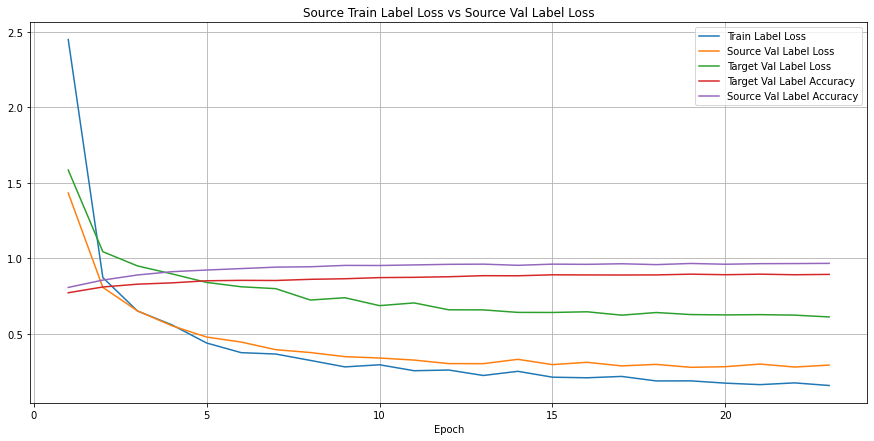

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

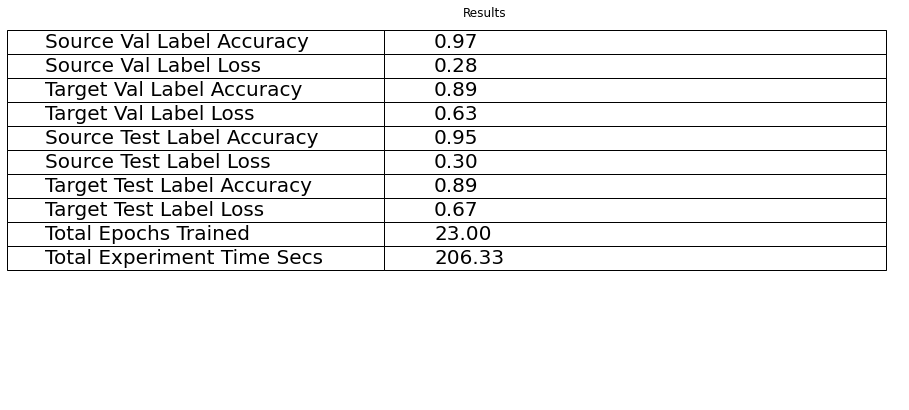

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

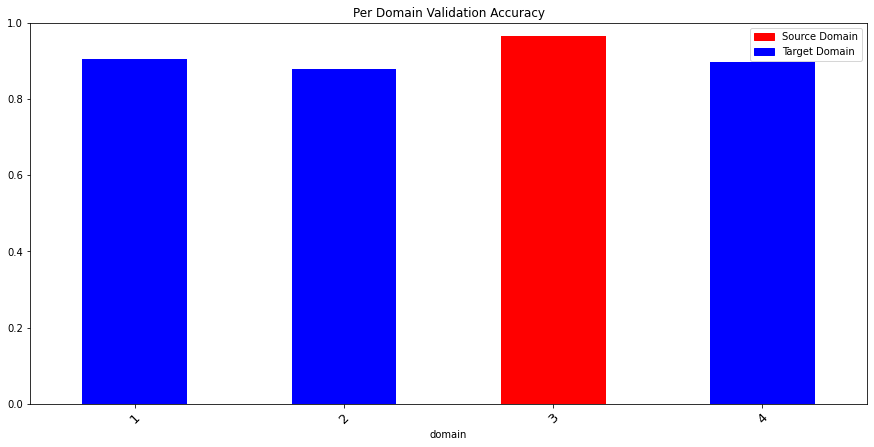

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9538461538461539 Target Test Label Accuracy: 0.8882478632478632
Source Val Label Accuracy: 0.9653846153846154 Target Val Label Accuracy: 0.8944444444444445


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "